In [1]:
import numpy as np
from numba import njit
from numpy.random import Generator, MT19937, SeedSequence
sq = SeedSequence(1234)
bit_generator = MT19937(sq)
gen = Generator(bit_generator)
for i in range(10):
    print(gen.random(1))
gen.integers(low=0,high=6,size=1)

[0.12038356]
[0.40370142]
[0.87770263]
[0.9565788]
[0.42646002]
[0.28304326]
[0.90094107]
[0.83083314]
[0.67528993]
[0.3977176]


array([5])

In [2]:
import numpy as np
import numba as nb
from numpy.random import PCG64
from timeit import timeit

bit_gen = PCG64()
next_d = bit_gen.cffi.next_double
state_addr = bit_gen.cffi.state_address

def rando(n, state):
    out = np.empty(n)
    for i in range(n):
        out[i]= next_d(state)
        
    return out

# Compile using Numba
randoj = nb.jit(rando, nopython=True)
# Must use state address not state with numba
n = 10**6

def numbacall():
    return randoj(n, state_addr)

rg = np.random.Generator(PCG64())

def numpycall():
    return rg.random(size=n)

# Check that the functions work
r1 = numbacall()
r2 = numpycall()
assert r1.shape == (n,)
assert r1.shape == r2.shape

t1 = timeit(numbacall, number=1)
print(f'{t1:.2f} secs for {n} PCG64 (Numba/PCG64) gaussian randoms')
t2 = timeit(numpycall, number=1)
print(f'{t2:.2f} secs for {n} PCG64 (NumPy/PCG64) gaussian randoms')


0.01 secs for 1000000 PCG64 (Numba/PCG64) gaussian randoms
0.00 secs for 1000000 PCG64 (NumPy/PCG64) gaussian randoms


In [4]:
import numpy as np
def correl(func,start,dist):
    N = (len(func)-start-dist)
    if (dist==0):
        return 1/N*np.sum(func[start:]**2)-np.sum(func[start:])**2/N**2
    else:
        return 1/N*np.sum(func[start:-dist]*func[start+dist:])-np.sum(func[start:-dist])**2/N**2

def autocorrel(func,start,dist):
    c_0 = correl(func,start,0)
    autocorr = 1/2
    cor = correl(func,start,1)/c_0
    iter =1
    while (cor>10**(-4)):
        autocorr += cor
        iter +=1
        cor = correl(func,start,iter)
    return autocorr

def correl_vec(func,start,comps):
    c_0 = correl(func,start,0)
    vec =np.zeros(comps)
    vec[0] = 1/2
    for i in range(1,comps):
        vec[i] = correl(func,start,i)/c_0
    return vec

In [20]:
import numpy as np
def correl(func,start,dist):
    N = (len(func)-start-dist)
    if (dist==0):
        return 1/N*np.sum(func[start:]**2)-np.sum(func[start:])**2/N**2
    else:
        return 1/N*np.sum(func[start:-dist]*func[start+dist:])-np.sum(func[start:-dist])**2/N**2

def autocorrel(func,start,dist):
    c_0 = correl(func,start,0)
    autocorr = 1/2
    cor = correl(func,start,1)/c_0
    iter =1
    while (cor>10**(-4)):
        autocorr += cor
        iter +=1
        cor = correl(func,start,iter)
    return autocorr

def correl_vec(func,start,comps):
    c_0 = correl(func,start,0)
    vec =np.zeros(comps)
    vec[0] = 1/2
    for i in range(1,comps):
        vec[i] = correl(func,start,i)/c_0
    return vec
def bootstrap(sample):
    n = len(sample)
    btstrp = np.zeros((n*np.log(n)**2))
    for i in range(n*np.log(n)**2):
        rand = randoj(n,state_addr)
        for pos in range(n):
            btstrp[pos] = sample[int(100*rand[pos])]
    return btstrp

def jackkknife(sample,cut_size):
    jack_mat = np.zeros((len(sample)//cut_size,len(sample)-cut_size))
    for i in range(len(sample)//cut_size):
        jack_mat[i,0:i*cut_size]= sample[0:i*cut_size]
        jack_mat[i,i*cut_size::] = sample[(i+1)*cut_size::]
    return jack_mat


def jack_mean(sample,cut_size):
    return np.mean(jackkknife(sample,cut_size),axis=1)

def jack_var(sample,cut_size):
    return np.std(jack_mean(sample,cut_size))

def bootstrap_mean(sample):
    mean_mat = np.mean(bootstrap(sample),axis=1)
    return np.std(mean_mat)




In [23]:
import numpy as np
def correl(func,start,dist):
    N = (len(func)-start-dist)
    if (dist==0):
        return 1/N*np.sum(func[start:]**2)-np.sum(func[start:])**2/N**2
    else:
        return 1/N*np.sum(func[start:-dist]*func[start+dist:])-np.sum(func[start:-dist])**2/N**2

def autocorrel(func,start,dist):
    c_0 = correl(func,start,0)
    autocorr = 1/2
    cor = correl(func,start,1)/c_0
    iter =1
    while (cor>10**(-4)):
        autocorr += cor
        iter +=1
        cor = correl(func,start,iter)
    return autocorr

def correl_vec(func,start,comps):
    c_0 = correl(func,start,0)
    vec =np.zeros(comps)
    vec[0] = 1/2
    for i in range(1,comps):
        vec[i] = correl(func,start,i)/c_0
    return vec
def bootstrap(sample):
    n = len(sample)
    btstrp = np.zeros((n*np.log(n)**2))
    for i in range(n*np.log(n)**2):
        rand = randoj(n,state_addr)
        for pos in range(n):
            btstrp[pos] = sample[int(100*rand[pos])]
    return btstrp

def jackkknife(sample,cut_size):
    jack_mat = np.zeros((len(sample)//cut_size,len(sample)-cut_size))
    for i in range(len(sample)//cut_size):
        jack_mat[i,0:i*cut_size]= sample[0:i*cut_size]
        jack_mat[i,i*cut_size::] = sample[(i+1)*cut_size::]
    return jack_mat


def jack_mean(sample,cut_size):
    return np.mean(jackkknife(sample,cut_size),axis=1)

def jack_var(sample,cut_size):
    return np.std(jack_mean(sample,cut_size))

def bootstrap_mean(sample):
    mean_mat = np.mean(bootstrap(sample),axis=1)
    return np.std(mean_mat)


def reweighting(beta,beta0,obs,Ham):
    reweighted_mean = np.zeros_like(beta)
    for i in range(len(beta)):
        reweighted_mean[i] = np.sum(obs*np.exp(-(beta[i]-beta0)*Ham))/np.sum(np.exp(-(beta[i]-beta0)*Ham))
    return reweighted_mean
def error_reweight(beta,beta0,obs,Ham,jack_cut):
    obs_jack = jackkknife(obs,jack_cut)
    Ham_jack = jackkknife(Ham,jack_cut)
    jack_vals = np.zeros((len(beta),obs_jack.shape[0]))
    for i in range(obs_jack.shape[0]):
        jack_vals[:,i] = reweighting(beta,beta0,obs_jack[i],Ham_jack[i])
    return np.std(jack_vals,axis=1), np.mean(jack_vals,axis=1)

0.59
[18, 19, 24, 33]


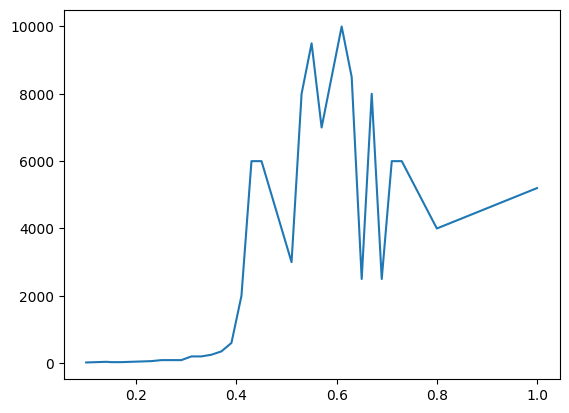

In [5]:
import matplotlib.pyplot as plt
start_pos = list(np.array([20,40,30,30,40,50,60,90,90,90,200,200,250,350,600,2000,6000,6000,50000,-1,3000,8000,9500,7000,-1,10000,8500,2500,8000,2500,6000,6000,4000,80000,5200]))

beta = list(np.zeros(35))
for i in range(30):
    beta[i+2]= 0.15 +0.6/30*i
for i in range(2):
    beta[i] = 0.1+0.04*i
for i in range(3):
    beta[i+32]= 0.8+ 0.1*i
indx = []
print(beta[24])
for i in range(35):
    if (start_pos[i]>10000 or start_pos[i]<0):
        indx.append(i)
print(indx)
i =0
while (i<len(start_pos)):
    if (start_pos[i]>10000 or start_pos[i]<0):
        del start_pos[i]
        del beta[i]
        i -=1
    i+=1

fig, ax = plt.subplots(1,1)
ax.plot(beta,start_pos)
plt.show()

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv('mag_heatb_init.txt',header= None,sep='\t')
print(data.shape)
data = data.to_numpy()

(35, 200001)


In [60]:
remeasured_data = pd.read_csv('Mag_store.txt',header= None,sep='\t')
print(remeasured_data.shape)
remeasured_data = remeasured_data.to_numpy()

(4, 300001)


In [62]:
data = data/128**2
remeasured_data = remeasured_data/128**2

In [7]:
data_mag = data[:,:-2]/128**2
data_ham = pd.read_csv("ham_heatb_init.txt",header=None,sep="\t").to_numpy()[:,:-2]/128**2

In [7]:
data_ham.shape

(4, 300001)

In [ ]:
with open("Mag_store1.txt","w") as file:
    for i in range(35):
        for j in range(data.shape[1]):
            file.write("{}\t".format(data[i,j]))
        file.write("\n")

In [18]:
re_measured_start = np.array([6000,40000,140000,8000])
start_pos = np.array(start_pos)
components = 2000
cor_mat = np.zeros((len(start_pos),components))
for i in range(len(start_pos)):
    cor_mat[i,:] = correl_vec(data[i,:-3],start_pos[i],components)

remeasured_cor = np.zeros((4,components))
for i in range(4):
    remeasured_cor[i,:] = correl_vec(remeasured_data[i,:-3],re_measured_start[i],components)


In [12]:
correl(data[0,:-3],200,0)

3.391898021044564e-05

In [100]:
remeasured_cor = np.zeros((4,components))
for i in range(4):
    remeasured_cor[i,:] = correl_vec(remeasured_data[i,:-3],re_measured_start[i],components)

In [16]:
params = np.zeros(start_pos.shape[0])
fit_error = np.zeros(start_pos.shape[0])
fit_bound =np.zeros(start_pos.shape[0])

In [16]:
dist = np.arange(components)
end = 900
beta=28
fig, ax = plt.subplots(1,1)
ax.plot(dist[1:end],cor_mat[beta,1:end])
plt.show()

NameError: name 'components' is not defined

/tmp/ipykernel_5460/1620465374.py:6: RuntimeWarning: overflow encountered in exp
  return np.exp(-b*x)


[0.00090614]


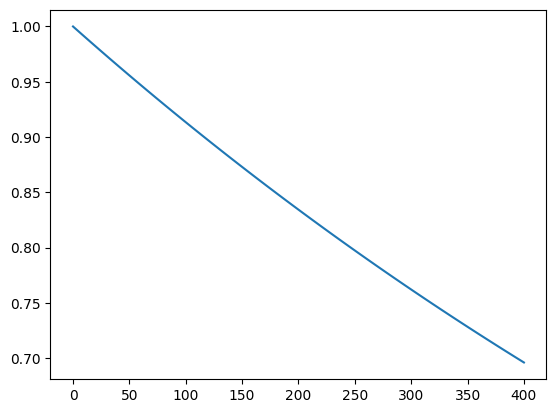

In [129]:
end = 400
from scipy.optimize import curve_fit
# def exp_fit(x,b,c):
#     return np.exp(-b*x)+c
def exp_fit(x,b):
    return np.exp(-b*x)
fit_bound[beta] = end
param, error =curve_fit(f=exp_fit,xdata=dist[1:end],ydata=cor_mat[beta,1:end])
# print(error[0])
# params[beta] = float(param[0])
# fit_error[beta] = float(error[0][0])
print(param)
params[beta] = param
fit_error[beta] = error
steps = np.linspace(0,end)
fig, ax = plt.subplots(1,1)
# ax.scatter(dist[1:end],cor_mat[beta,1:end])
# ax.plot(steps,exp_fit(steps,param[0],param[1]))
ax.plot(steps,exp_fit(steps,param))
plt.show()

In [131]:
with open("fit_params.txt","w") as save:
    for i in range(len(params)):
        save.write("{:.6e}\t".format(params[i]))
        save.write("{:.6e}\t".format(fit_error[i]))
        save.write("{:.6e}\n".format(fit_bound[i]))

In [114]:
import numpy as np
import mpmath as ma

def correl(func,start,dist):
    N = (len(func)-start-dist)
    if (dist==0):
        return 1/N*np.sum(func[start:]**2)-np.sum(func[start:])**2/N**2
    else:
        return 1/N*np.sum(func[start:-dist]*func[start+dist:])-np.sum(func[start:-dist])**2/N**2

def autocorrel(func,start,dist):
    c_0 = correl(func,start,0)
    autocorr = 1/2
    cor = correl(func,start,1)/c_0
    iter =1
    while (cor>10**(-4)):
        autocorr += cor
        iter +=1
        cor = correl(func,start,iter)
    return autocorr

def correl_vec(func,start,comps):
    c_0 = correl(func,start,0)
    vec =np.zeros(comps)
    vec[0] = 1/2
    for i in range(1,comps):
        vec[i] = correl(func,start,i)/c_0
    return vec
def bootstrap(sample):
    n = len(sample)
    btstrp = np.zeros((n*np.log(n)**2))
    for i in range(n*np.log(n)**2):
        rand = randoj(n,state_addr)
        for pos in range(n):
            btstrp[pos] = sample[int(100*rand[pos])]
    return btstrp

def jackkknife(sample,cut_size):
    jack_mat = np.zeros((len(sample)//cut_size,len(sample)-cut_size))
    for i in range(len(sample)//cut_size):
        jack_mat[i,0:i*cut_size]= sample[0:i*cut_size]
        jack_mat[i,i*cut_size::] = sample[(i+1)*cut_size::]
    return jack_mat


def jack_mean(sample,cut_size):
    return np.mean(jackkknife(sample,cut_size),axis=1)

def jack_var(sample,cut_size):
    return np.std(jack_mean(sample,cut_size))

def bootstrap_mean(sample):
    mean_mat = np.mean(bootstrap(sample),axis=1)
    return np.std(mean_mat)

V = 1
def reweighting(beta,beta0,obs,Ham):
    reweighted_mean = np.zeros(len(beta))
    for i in range(len(beta)):
        mean_sum =0
        partition = 0
        sign = np.sign(beta[i]-beta0)
        for dpoint in range(len(Ham)):
            if 
            mean_sum+= obs[dpoint]*V*ma.exp(-(beta[i]-beta0)*Ham[dpoint])**V
            partition += ma.exp(-(beta[i]-beta0)*Ham[dpoint])**V
        print(partition/len(Ham))
        reweighted_mean[i] = mean_sum/partition
    return reweighted_mean/V
def error_reweight(beta,beta0,obs,Ham,jack_cut):
    obs_jack = jackkknife(obs,jack_cut)
    Ham_jack = jackkknife(Ham,jack_cut)
    jack_vals = np.zeros((len(beta),obs_jack.shape[0]))
    for i in range(obs_jack.shape[0]):
        jack_vals[:,i] = reweighting(beta,beta0,obs_jack[i],Ham_jack[i])
    return np.std(jack_vals,axis=1), np.mean(jack_vals,axis=1)

In [10]:
mean_mag = np.mean(np.abs(data_mag),axis=1)

In [117]:
count =0
for i in range(data_ham.shape[0]):
    for j in range(data_ham.shape[1]):
        if (data_ham[i,j]>0):
            count+=1
count

0

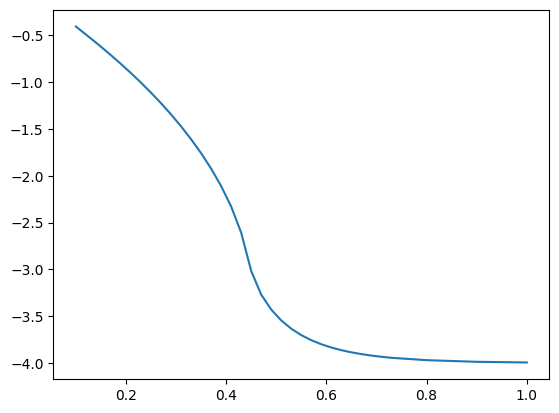

In [116]:
fig, ax = plt.subplots(1,1)
ax.plot(beta,np.mean(data_ham,axis=1))

In [51]:
def reweighting(beta,beta0,obs,Ham):
    reweighted_mean = np.zeros((len(beta),len(Ham)))
    for i in range(len(beta)):
        sign = np.sign(beta[i]-beta0)
        reweighted_mean[i,:] =np.exp(-(beta[i]-beta0)*Ham)**V*np.exp(-sign*)
        # reweighted_mean[i] = np.sum(((obs*V)**(1/V)*np.exp(-(beta[i]-beta0)*Ham))**V)/z
    return reweighted_mean/V

In [95]:
a= np.zeros(5)
ma.exp(data_ham[1,10000]*V)


mpf('1.8211013892340364e-4371')

In [60]:
absH = np.abs(data_ham)
countFit =np.zeros((35))
maxi = np.max(absH,axis=1)
mask = (np.dot(1/maxi,absH)>=0.96 and np.dot(1/maxi,absH)<=1.4)
for i in range(35):
    for j in range(absH.shape[1]):
        if (mask[i,j]):
            countFit[i] += 1

countFit/absH.shape[1]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

0.830965506883626
0.837269585945265
0.843621491878152
0.850021587537931
0.856470238533334
0.862967813246947
0.869514682856408
0.876111221355321
0.882757805574889
0.889454815205463
0.896202632817988
0.903001643886098
0.909852236807897
0.91675480292851
0.923709736562016
0.930717435014414
0.93777829860582
0.944892730693897
0.952061137696455
0.959283929114759
0.966561517557131
0.973894318762446
0.981282751623608
0.98872723821188
0.996228203800791
1.00378607689032
1.01140128923174
1.0190742758519
1.02680547507827
1.0345953285641
1.04244428131315
1.05035278170596
1.05832128152455
1.06635023597889
1.07444010373265
1.08259134692928
1.09080443121882
1.09907982578405
1.10741800336759
1.11581944029872
1.12428461652082
1.13281401561859
1.14140812484569
1.15006743515261
1.15879244121494
1.16758364146124
1.17644153810181
1.18536663715731
1.19435944848745
1.20342048582056


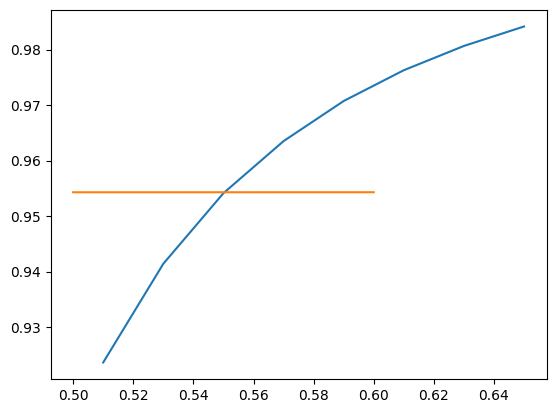

In [115]:
bn =35
beta = list(np.zeros(35))
for i in range(30):
    beta[i+2]= 0.15 +0.6/30*i
for i in range(2):
    beta[i] = 0.1+0.04*i
for i in range(3):
    beta[i+32]= 0.8+ 0.1*i
idx = 22
beta0 = beta[idx]
steps = 30
a_bd = beta0-0.05
b_bd = beta
beta_intvl = np.linspace(beta0-0.05,beta0+0.05)
mag = np.abs(data_mag[idx,:])
ham = data_ham[idx,:]
fig, ax = plt.subplots(1,1)
# reweighting(beta_intvl,beta0,mag[20000:40000],ham[20000:40000])
ax.plot(beta[20:28],mean_mag[20:28])
for i in range(1):
    ax.plot(beta_intvl,reweighting(beta_intvl,beta0,mag[20000:40000],ham[20000:40000]))
plt.show()

/tmp/ipykernel_6398/2426508995.py:58: RuntimeWarning: invalid value encountered in power
  reweighted_mean[i] = np.sum(((obs*V)**(1/V)*np.exp(-(beta[i]-beta0)*Ham))**V)/np.sum(np.exp(-(beta[i]-beta0)*Ham)**V)


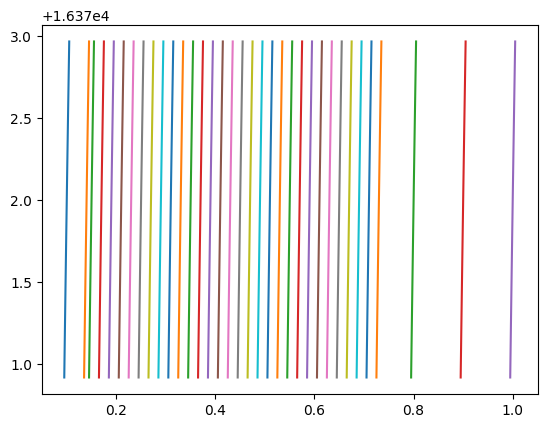

In [78]:
bn =35
beta = list(np.zeros(35))
for i in range(30):
    beta[i+2]= 0.15 +0.6/30*i
for i in range(2):
    beta[i] = 0.1+0.04*i
for i in range(3):
    beta[i+32]= 0.8+ 0.1*i

reweited_mag = np.zeros((35,30,2))
extended_beta = np.zeros((bn,30))
for idx in range(35):
    extended_beta[idx,:] = np.linspace(beta[idx]-0.005,beta[idx]+0.005,30)
    reweited_mag[idx,:,0], reweited_mag[idx,:,1] = error_reweight(extended_beta[idx,:],beta[idx],data_mag[idx,:],data_ham[idx,:],200)

fig ,ax = plt.subplots(1,1)
for i in range(bn):
    ax.plot(extended_beta[i,:],reweited_mag[idx,:,1])
    # plt.errorbar(x=extended_beta[i,:],y=reweited_mag[idx,:,1],yerr=reweited_mag[idx,:,0])
plt.show()

In [33]:
data_mag[5,:-1]*np.exp(-(extended_beta[5,10]-beta[5])*data_ham[5,:])

array([ 0.0022803 ,  0.0044561 ,  0.01440902, ..., -0.00469305,
       -0.00071966,  0.        ])

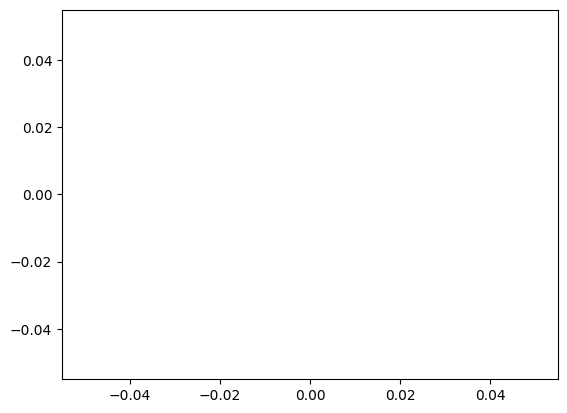

In [25]:
fig ,ax = plt.subplots(1,1)
for i in range(bn):
    ax.plot(extended_beta[i,:],reweited_mag[idx,:,1])
    # plt.errorbar(x=extended_beta[i,:],y=reweited_mag[idx,:,1],yerr=reweited_mag[idx,:,0])
plt.show()


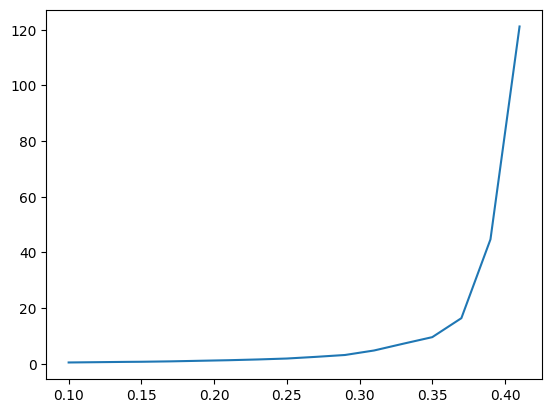

In [10]:
beta = list(np.zeros(35))
for i in range(30):
    beta[i+2]= 0.15 +0.6/30*i
for i in range(2):
    beta[i] = 0.1+0.04*i
for i in range(3):
    beta[i+32]= 0.8+ 0.1*i
fit_params = pd.read_csv("fit_params.txt",header=None,sep="\t").to_numpy()
fig, ax = plt.subplots(1,1)
ax.plot(beta[:16],1/fit_params[:16,0])
plt.show()
